In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

import blackjax

In [2]:
loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

In [3]:
def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return jnp.sum(logpdf)


logdensity = lambda x: logdensity_fn(**x)

In [4]:
inv_mass_matrix = np.array([0.5, 0.01])
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

In [5]:
initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = hmc.init(initial_position)
initial_state

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


HMCState(position={'loc': 1.0, 'log_scale': 1.0}, potential_energy=Array(34371.406, dtype=float32), potential_energy_grad={'loc': Array(-1246.4711, dtype=float32, weak_type=True), 'log_scale': Array(-63904.94, dtype=float32, weak_type=True)})

In [6]:
hmc_kernel = jax.jit(hmc.step)

In [7]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [8]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, hmc_kernel, initial_state, 10_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = jnp.exp(states.position["log_scale"])

CPU times: user 2.16 s, sys: 85.7 ms, total: 2.25 s
Wall time: 2.22 s


Text(0, 0.5, 'scale')

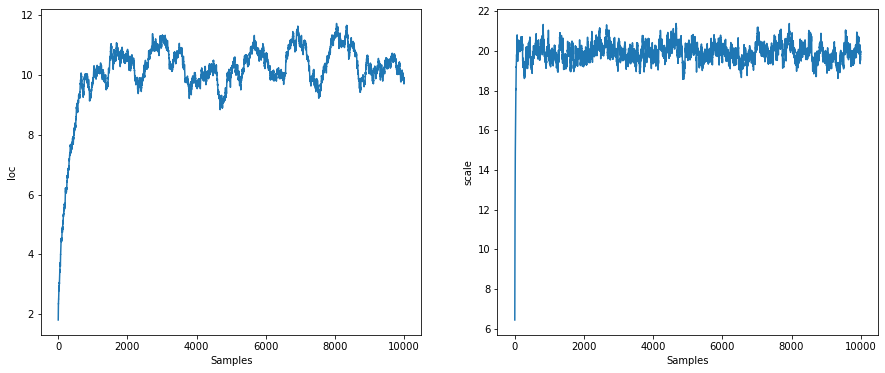

In [9]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale")

In [10]:
inv_mass_matrix = np.array([0.5, 0.01])
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [11]:
initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = nuts.init(initial_position)
initial_state

HMCState(position={'loc': 1.0, 'log_scale': 1.0}, potential_energy=Array(34371.406, dtype=float32), potential_energy_grad={'loc': Array(-1246.4711, dtype=float32, weak_type=True), 'log_scale': Array(-63904.94, dtype=float32, weak_type=True)})

In [12]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, nuts.step, initial_state, 4_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = jnp.exp(states.position["log_scale"])

CPU times: user 9.71 s, sys: 132 ms, total: 9.85 s
Wall time: 9.79 s


Text(0, 0.5, 'scale')

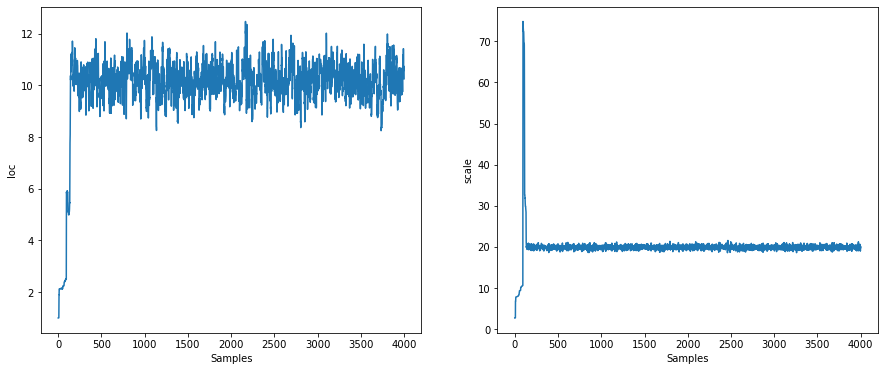

In [13]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale")